In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blackheads-data/Blackheads/valid/labels/WhatsApp-Image-2024-09-24-at-23-29-41_jpeg_jpg.rf.426bf6e38415cac6a61db94776c546ee.txt
/kaggle/input/blackheads-data/Blackheads/valid/labels/blackhead-17-_JPG_jpg.rf.f79934d8fff57cd317079d4db376c6ad.txt
/kaggle/input/blackheads-data/Blackheads/valid/labels/aug_1_77_0_206_jpeg.rf.5e7df1a5404840fec140d8231df08a75.txt
/kaggle/input/blackheads-data/Blackheads/valid/labels/comedones-black-dots-on-skin-600nw-1107538805_webp_jpg.rf.c34ae4506084782683691823a2527076.txt
/kaggle/input/blackheads-data/Blackheads/valid/labels/blackhead-2-_jpg.rf.98a6a990f7ccbf352c9c21fc0002d0d3.txt
/kaggle/input/blackheads-data/Blackheads/valid/labels/jik_jpg.rf.adbe18674c4668aafc0997cfba984735.txt
/kaggle/input/blackheads-data/Blackheads/valid/labels/blackhead_94_jpg.rf.9942b9dca25fbaf93f3ebe479f18aea2.txt
/kaggle/input/blackheads-data/Blackheads/valid/labels/blackhead_77_jpg.rf.39302800dc8d3df334da0a03ae1b961e.txt
/kaggle/input/blackheads-data/Blackheads/vali

In [3]:
!pip install ultralytics --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00:00:0100:01


In [4]:
from ultralytics import YOLO
import os
import shutil

# ================== 1. نسخ البيانات ==================
source_dir = "/kaggle/input/blackheads-data/Blackheads"  # غيّر المسار حسب مجلدك
target_dir = "/kaggle/working/Blackheads"
shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)

# ================== 2. تعديل الـ labels إلى class 0 ==================
for split in ["train", "valid", "test"]:
    labels_dir = os.path.join(target_dir, split, "labels")
    for filename in os.listdir(labels_dir):
        if filename.endswith(".txt"):
            path = os.path.join(labels_dir, filename)
            with open(path, "r") as f:
                lines = f.readlines()
            new_lines = ["0 " + " ".join(line.strip().split()[1:]) for line in lines]
            with open(path, "w") as f:
                f.write("\n".join(new_lines))

# ================== 3. إنشاء ملف data.yaml ==================
yaml_content = """
train: /kaggle/working/Blackheads/train/images
val: /kaggle/working/Blackheads/valid/images
test: /kaggle/working/Blackheads/test/images

nc: 1
names: ["Blackheads"]
"""
with open("data.yaml", "w") as f:
    f.write(yaml_content)

# ================== 4. تحميل YOLOv8l ==================
model = YOLO("yolov8l.pt")  # نسخة قوية نسبيًا

# ================== 5. تدريب مع Augmentations محسنة ==================
model.train(
    data="data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    name="blackheads_yolo_improved",
    degrees=10,
    translate=0.1,
    scale=0.4,
    shear=1.0,
    flipud=0.3,
    fliplr=0.5,
    hsv_h=0.015,
    hsv_s=0.6,
    hsv_v=0.4,
    mosaic=0.5,      
    mixup=0.1,
    close_mosaic=5,
    cos_lr=True,
    patience=20,
    cache=True,
    lr0=0.001,
    lrf=0.01,
    warmup_epochs=2
)

# ================== 6. حفظ أفضل نسخة ==================
best_model_path = "runs/detect/blackheads_yolo_improved/weights/best.pt"
shutil.copy(best_model_path, "/kaggle/working/best_blackheads_model.pt")

# ================== 7. تقييم الأداء ==================
metrics = model.val(
    data="data.yaml",
    split="test",  # أو "val" حسب ما تفضّل
    iou=0.5,
    conf=0.25,
    plots=True
)

# عرض النتائج
print(metrics.results_dict)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 83.7M/83.7M [00:00<00:00, 174MB/s]


Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=5, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=blackheads_yolo_improved, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 917.1±373.8 MB/s, size: 35.4 KB)


train: Scanning /kaggle/working/Blackheads/train/labels... 1682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1682/1682 [00:01<00:00, 1433.39it/s]

train: New cache created: /kaggle/working/Blackheads/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 195, len(boxes) = 9088. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.9GB RAM): 100%|██████████| 1682/1682 [00:01<00:00, 876.86it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 368.5±58.8 MB/s, size: 39.0 KB)


val: Scanning /kaggle/working/Blackheads/valid/labels... 303 images, 0 backgrounds, 0 corrupt: 100%|██████████| 303/303 [00:00<00:00, 1204.43it/s]

val: New cache created: /kaggle/working/Blackheads/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 47, len(boxes) = 1888. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.3GB RAM): 100%|██████████| 303/303 [00:00<00:00, 508.32it/s]


Plotting labels to runs/detect/blackheads_yolo_improved/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/blackheads_yolo_improved
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.32G      2.648      3.206      2.275          8        640: 100%|██████████| 106/106 [01:19<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/engine/validator.py:286: RuntimeWarning: invalid value encountered in greater_equal
  matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        303       1888    0.00776      0.099     0.0031    0.00112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.57G      2.637      3.136      2.282          4        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888     0.0195      0.309     0.0123    0.00374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.65G      2.541      3.046      2.231         16        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888       0.12      0.125     0.0536      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.77G       2.49      2.998      2.148         50        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.107      0.137     0.0571     0.0193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.71G      2.445      2.907      2.112         14        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        303       1888     0.0988      0.254     0.0643     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.75G      2.417      2.885      2.107         11        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888     0.0312      0.347     0.0192    0.00612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.69G      2.437      2.885      2.101         19        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        303       1888     0.0454       0.28     0.0251    0.00889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.67G      2.374      2.823      2.058         12        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.113      0.126     0.0598     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       9.7G      2.386      2.862      2.063         28        640: 100%|██████████| 106/106 [01:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        303       1888     0.0941      0.222     0.0539     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.72G      2.343      2.804      2.023         11        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        303       1888     0.0925      0.314     0.0709     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.77G       2.37      2.829      2.032         12        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.198      0.153      0.092     0.0309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.71G      2.334      2.793      2.024          8        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.211      0.173      0.103     0.0369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.79G       2.36      2.772      2.021          8        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        303       1888      0.159      0.199     0.0839       0.03



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.73G      2.336      2.732      1.996          6        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.177      0.244      0.107     0.0363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       9.7G      2.332      2.747      2.003         12        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.148      0.261     0.0912     0.0294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.66G      2.333      2.767      2.009          2        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.126       0.17     0.0619     0.0202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.65G      2.333      2.744      1.985         35        640: 100%|██████████| 106/106 [01:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        303       1888       0.13      0.173     0.0691     0.0258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.67G      2.329      2.719      1.974          6        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.218      0.219      0.118     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.65G      2.321      2.729      1.986         10        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.195      0.247      0.124     0.0418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.62G      2.308      2.717      1.969         26        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.174      0.229      0.117     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.74G      2.298        2.7      1.979         12        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.205      0.212      0.117     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.67G      2.296      2.687      1.974          8        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.188      0.245      0.126     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.65G      2.291      2.714      1.937          3        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888       0.19        0.2      0.103     0.0354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.77G      2.277      2.709      1.949         15        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.156      0.244     0.0977      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.68G      2.283      2.706       1.96         13        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888       0.16      0.264      0.115     0.0375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.63G      2.299      2.683      1.943         15        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        303       1888      0.176      0.222      0.101     0.0373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.66G      2.299        2.7      1.947         15        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.181      0.219      0.125     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.62G      2.269       2.67       1.94          8        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.192      0.185      0.107     0.0374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.68G      2.287      2.703       1.96          5        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.213       0.18       0.11     0.0387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.67G      2.256      2.652      1.919          8        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.199      0.191      0.106     0.0387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       9.7G      2.266      2.662      1.948         17        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.238      0.184      0.126      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.63G      2.272      2.653      1.927         15        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.221      0.204      0.119     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.79G      2.253      2.663      1.925         28        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.183      0.246      0.115     0.0418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.62G      2.277      2.662      1.928         20        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888       0.19      0.189      0.102     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.65G      2.265      2.644      1.945          4        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        303       1888      0.211       0.17      0.119     0.0435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.66G      2.232      2.635      1.923          9        640: 100%|██████████| 106/106 [01:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888        0.2      0.245      0.129     0.0456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.74G      2.254       2.63       1.92         13        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.228      0.184      0.133     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.66G      2.249      2.612      1.912         11        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.194      0.189      0.113     0.0416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.65G      2.229      2.621       1.91         16        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.218      0.159      0.118     0.0418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.72G      2.232        2.6       1.91         33        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.183      0.244      0.128     0.0447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.68G      2.231      2.575      1.888         31        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.205      0.221      0.125     0.0435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.62G       2.21       2.59      1.893          3        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.211      0.207      0.134     0.0479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.65G      2.235        2.6      1.897          6        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.186      0.286       0.13     0.0465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.77G      2.251      2.596       1.92         27        640: 100%|██████████| 106/106 [01:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.209      0.224      0.146     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.64G      2.208      2.584      1.896         13        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.245      0.177       0.14     0.0512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.71G      2.207       2.57       1.88         13        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.228      0.192      0.123     0.0441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.67G      2.216      2.564      1.883         36        640: 100%|██████████| 106/106 [01:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

                   all        303       1888      0.251       0.13      0.111     0.0407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.62G      2.209      2.563      1.877         21        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        303       1888      0.223      0.213       0.14     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.68G      2.204       2.57      1.893         16        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.243      0.206      0.146     0.0501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       9.7G       2.22      2.571      1.889         15        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.225      0.216      0.141     0.0502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.69G      2.191      2.577      1.902         10        640: 100%|██████████| 106/106 [01:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.187      0.266      0.133     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.66G       2.21      2.566      1.883         23        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.214      0.234      0.142     0.0524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.66G      2.185      2.557      1.877         10        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.212      0.245       0.15      0.053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.72G      2.201      2.533      1.893          9        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.222      0.234      0.141      0.051



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.72G       2.22      2.556       1.88         37        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.245      0.199      0.143     0.0513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.77G      2.213      2.519      1.875         19        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.235      0.221      0.145     0.0546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.78G       2.18      2.547      1.869          3        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.258      0.238      0.158     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.61G      2.181      2.518      1.862          3        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.246      0.222      0.136     0.0523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.77G      2.165      2.485      1.834         33        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.244      0.236      0.153     0.0554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.66G      2.179      2.513      1.855         14        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.243      0.218      0.145     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.69G      2.162      2.518      1.848          3        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.224      0.263      0.147     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       9.7G      2.163      2.482      1.855          5        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

                   all        303       1888       0.23      0.211       0.14     0.0514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.73G      2.188      2.513      1.875         11        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

                   all        303       1888      0.233      0.242      0.144     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.71G      2.149      2.514      1.848         27        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.242      0.217       0.14     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.63G      2.155       2.51      1.845          6        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888       0.25      0.236      0.147     0.0522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.75G      2.149      2.479      1.833          6        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.256      0.246      0.157     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.79G      2.152      2.459      1.834         22        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.271      0.228      0.161     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.71G      2.153      2.468      1.834          4        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.269      0.228      0.164     0.0581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.75G      2.143      2.472       1.84         34        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.251      0.214      0.151     0.0554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.66G      2.167      2.489      1.847          6        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888       0.24      0.236      0.144     0.0515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.76G      2.145      2.475      1.836         13        640: 100%|██████████| 106/106 [01:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888       0.26      0.232      0.146     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.73G      2.162      2.451      1.828         12        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.247      0.254       0.16     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.79G      2.142      2.439       1.82         15        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.261      0.269      0.162     0.0598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.76G      2.142      2.432      1.832         15        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.277      0.246      0.171     0.0621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.81G      2.137      2.467      1.834         18        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.271      0.248      0.165     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.71G      2.141       2.46      1.848          9        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.255      0.243      0.152      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      9.79G      2.127      2.441      1.834         10        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.268      0.235      0.159     0.0585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.62G      2.125      2.423       1.82         22        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.282       0.23      0.168     0.0605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.77G      2.143      2.477      1.819          1        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.262      0.236      0.166     0.0596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.65G      2.135      2.425      1.821         38        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.262      0.247      0.162     0.0596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.68G       2.11      2.427      1.812         11        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.277      0.256      0.167     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.68G      2.103      2.414        1.8         16        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.283      0.252      0.174     0.0636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.78G       2.13      2.427      1.829          8        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.293      0.248      0.181     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.66G      2.119      2.416      1.821          3        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.278      0.255      0.173     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.71G      2.117      2.417      1.834         22        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.281      0.242      0.177     0.0647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.66G      2.104      2.436      1.808          3        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888       0.28      0.238      0.172     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.78G      2.123      2.407      1.806         26        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.279      0.252      0.172     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.76G      2.123      2.419      1.825          9        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.284      0.255      0.178     0.0637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.69G      2.105      2.424      1.828          4        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.278      0.261      0.172     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.66G      2.116      2.394      1.809         27        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.287      0.244      0.174     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.71G      2.114      2.414      1.823         12        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.285      0.243      0.173     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.71G      2.096      2.395      1.805         21        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.292      0.253      0.174     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      9.65G      2.109      2.377      1.795         10        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.281      0.271      0.174     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.62G      2.103      2.391       1.81         13        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.287      0.253      0.179     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.69G      2.125      2.409      1.831         24        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

                   all        303       1888      0.277      0.261      0.172     0.0638


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.67G      2.107       2.39      1.819         24        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888       0.28      0.265      0.176     0.0639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      9.68G      2.099      2.365      1.815          2        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.292      0.253      0.178      0.064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.77G        2.1      2.359      1.814          5        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

                   all        303       1888      0.285      0.256      0.179     0.0649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.75G      2.083       2.33      1.804         12        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.283      0.255      0.179     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.78G      2.089      2.335      1.805          9        640: 100%|██████████| 106/106 [01:22<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]

                   all        303       1888      0.283      0.255       0.18     0.0651



100 epochs completed in 2.505 hours.
Optimizer stripped from runs/detect/blackheads_yolo_improved/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/blackheads_yolo_improved/weights/best.pt, 87.7MB

Validating runs/detect/blackheads_yolo_improved/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        303       1888      0.293      0.247      0.181     0.0656
Speed: 0.2ms preprocess, 16.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/blackheads_yolo_improved
Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.7±8.5 MB/s, size: 42.5 KB)


val: Scanning /kaggle/working/Blackheads/test/labels... 186 images, 1 backgrounds, 0 corrupt: 100%|██████████| 186/186 [00:00<00:00, 731.69it/s]

val: New cache created: /kaggle/working/Blackheads/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 29, len(boxes) = 993. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.2GB RAM): 100%|██████████| 186/186 [00:00<00:00, 856.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        186        993       0.58     0.0514      0.308      0.158
Speed: 2.1ms preprocess, 37.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/blackheads_yolo_improved2
{'metrics/precision(B)': 0.5795454545454546, 'metrics/recall(B)': 0.0513595166163142, 'metrics/mAP50(B)': 0.30823320013979627, 'metrics/mAP50-95(B)': 0.15772781544120484, 'fitness': 0.172778353911064}



image 1/1 /kaggle/input/ddddddddd/OIP.webp: 576x640 1 Blackheads, 61.0ms
Speed: 1.8ms preprocess, 61.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)
Results saved to runs/detect/predict4


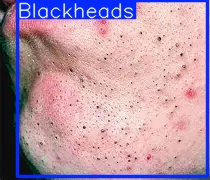

In [11]:
from ultralytics import YOLO
from IPython.display import Image, display
import os

# تحميل أفضل نموذج تم تدريبه
model = YOLO("/kaggle/working/best_blackheads_model.pt")

# التنبؤ على صورة اختبار
results = model.predict(
    source="/kaggle/input/ddddddddd/OIP.webp",
    conf=0.1,
    iou=0.5,
    save=True,
    show_conf=False,     # إخفاء النسبة المئوية
    show_labels=True     # عرض اسم الكلاس "Acne" (غيّره لـ False لو مش عايزه يظهر)
)

# عرض النتيجة
output_dir = results[0].save_dir
image_files = [f for f in os.listdir(output_dir) if f.endswith((".jpg", ".jpeg", ".png"))]

if image_files:
    display(Image(filename=os.path.join(output_dir, image_files[0])))
else:
    print("❌ لم يتم العثور على صورة ناتجة.")


In [7]:
from ultralytics import YOLO

# تحميل أفضل نموذج
model = YOLO("/kaggle/working/best_blackheads_model.pt")  # أو أي مسار لنموذجك

# تقييم النموذج على مجموعة الـ validation أو test
metrics = model.val(
    data="data.yaml",    # نفس ملف الداتا المستخدم في التدريب
    split="test",        # أو "val" لو عايز تستخدم مجموعة التحقق
    iou=0.5,
    conf=0.25,
    plots=True           # يرسم لك confusion matrix ونتائج إضافية
)

# طباعة النتائج
print(metrics.results_dict)


Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 936.3±201.1 MB/s, size: 32.5 KB)


val: Scanning /kaggle/working/Blackheads/test/labels.cache... 186 images, 1 backgrounds, 0 corrupt: 100%|██████████| 186/186 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 29, len(boxes) = 993. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        186        993       0.58     0.0514      0.308      0.158
Speed: 1.8ms preprocess, 37.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val
{'metrics/precision(B)': 0.5795454545454546, 'metrics/recall(B)': 0.0513595166163142, 'metrics/mAP50(B)': 0.30823320013979627, 'metrics/mAP50-95(B)': 0.15772781544120484, 'fitness': 0.172778353911064}


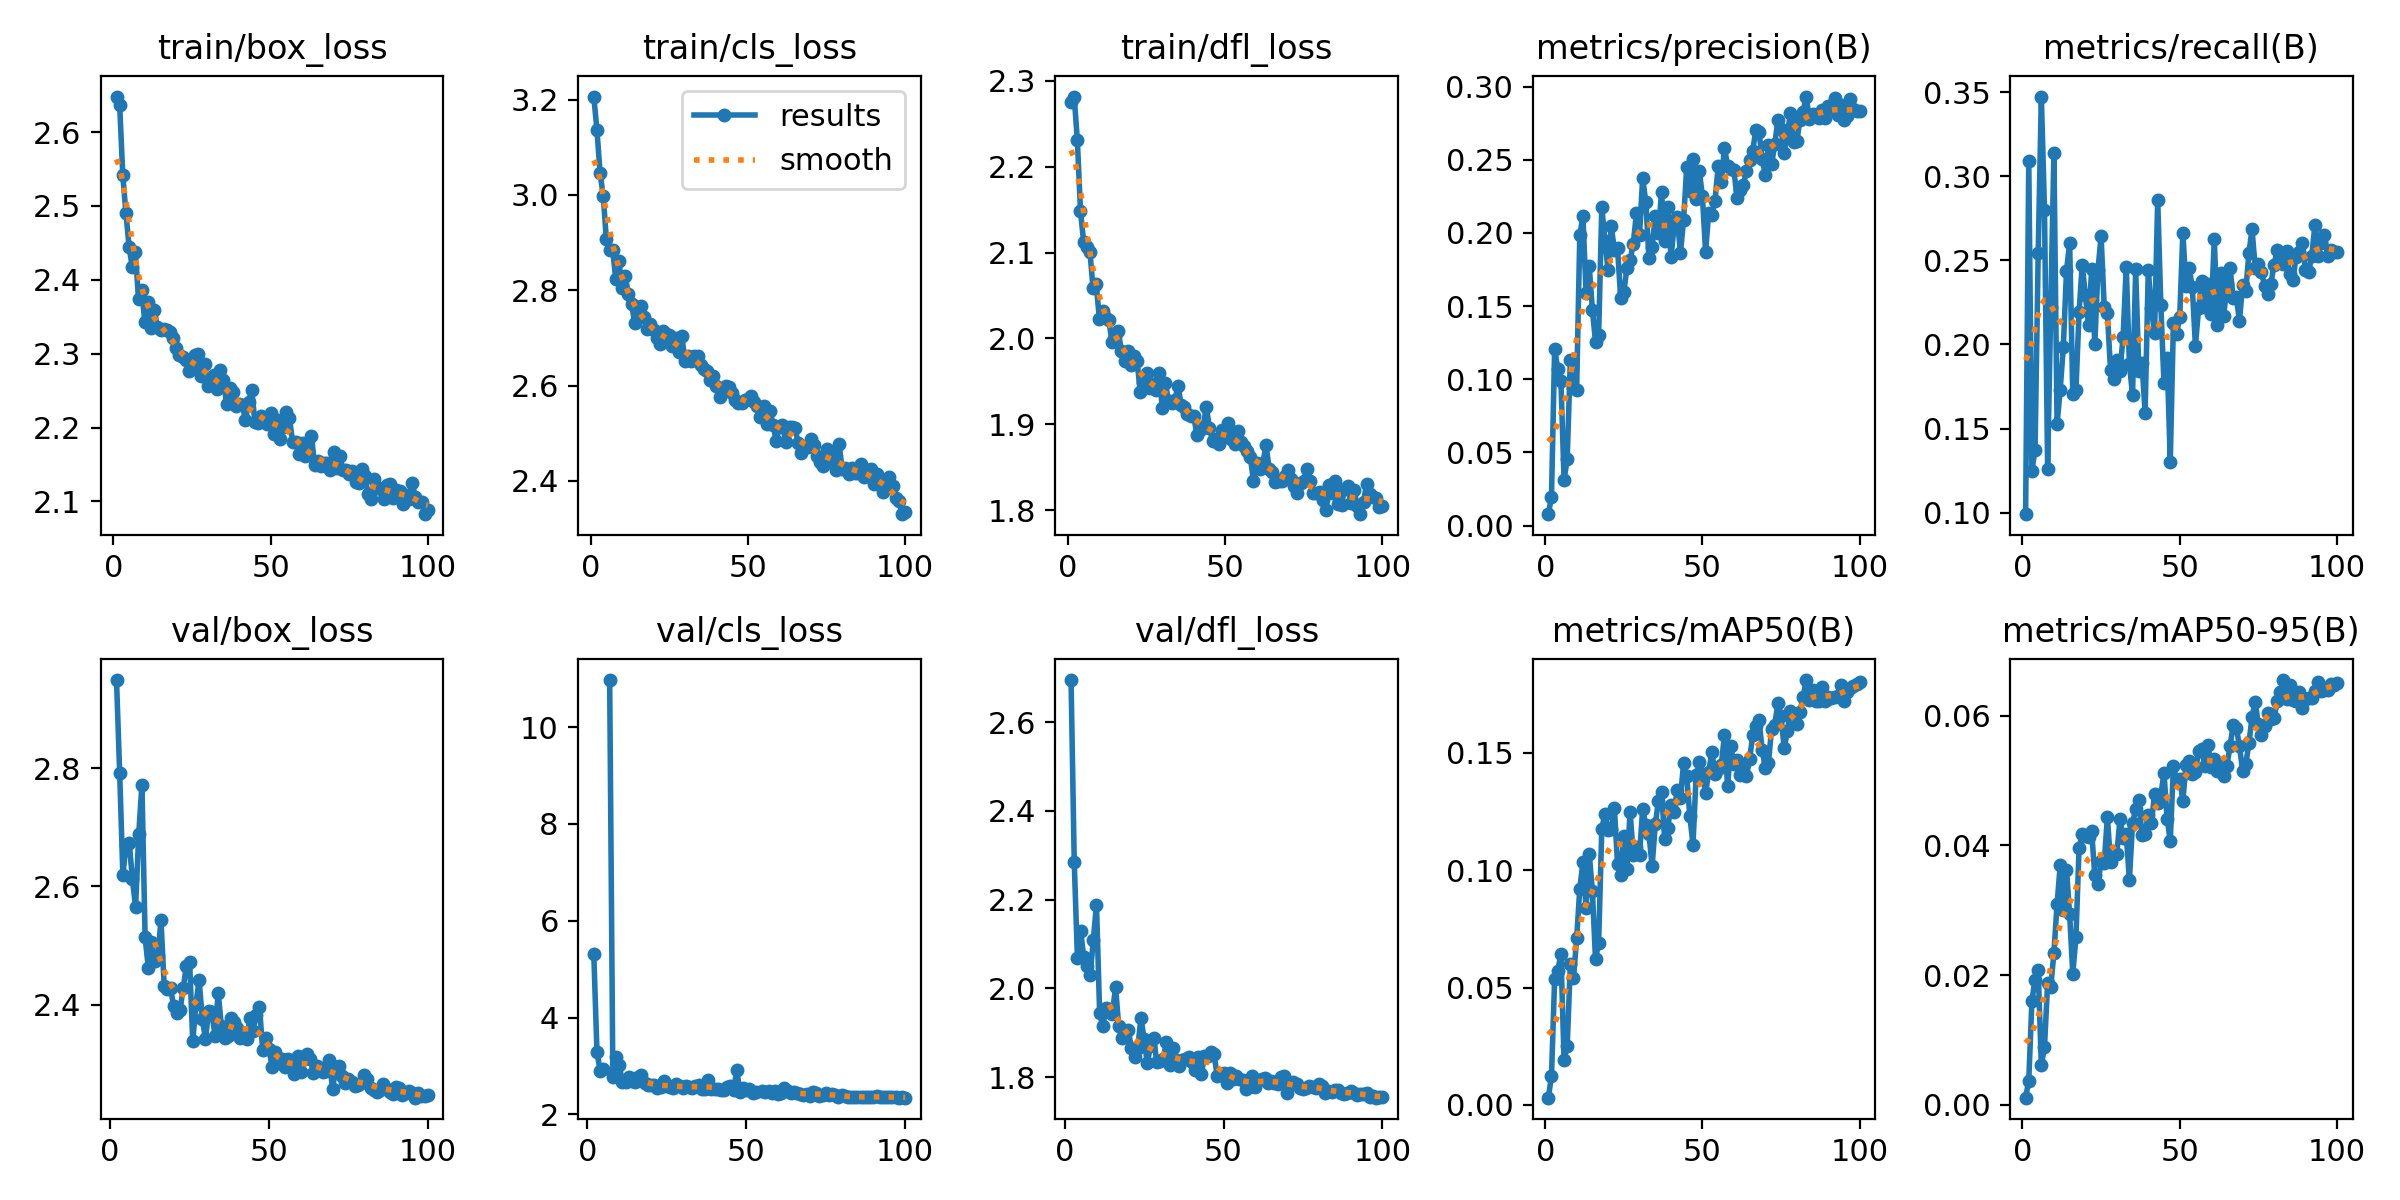

In [8]:
from IPython.display import Image, display

# Displaying the training and evaluation curves
results_path = "/kaggle/working/runs/detect/blackheads_yolo_improved/results.png"
display(Image(filename=results_path))